In [56]:
%%HTML
<style> code {background-color : orange !important;} </style>

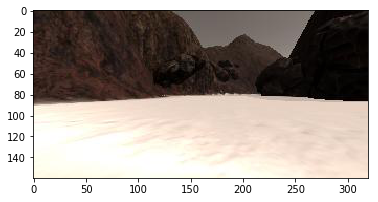

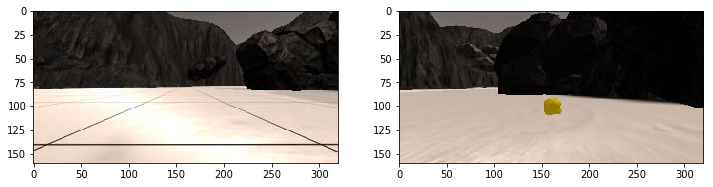

In [57]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
plt.close('all')
# Read in the sample image
#image = mpimg.imread('E:\\udacity\\IMG\\robocam_2017_05_24_20_33_27_986.jpg')
path = 'E:\\udacity\\test_dataset\\IMG\\*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)
plt.show()

example_grid = 'E:\\udacity\\calibration_images\\example_grid1.jpg'
example_rock = 'E:\\udacity\\calibration_images\\example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)


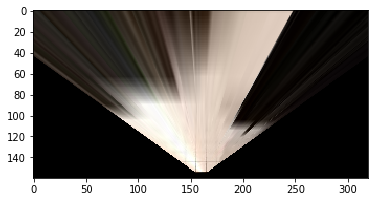

In [58]:
def perspect_transform1(img):
    img_size = (img.shape[1], img.shape[0])
    # Define calibration box in source (actual) and destination (desired) coordinates
    # These source and destination points are defined to warp the image
    # to a grid where each 10x10 pixel square represents 1 square meter
    dst_size = 5 
    # Set a bottom offset to account for the fact that the bottom of the image 
    # is not the position of the rover but a bit in front of it
    bottom_offset = 6
    src = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    dst = np.float32([[img_size[0]/2 - dst_size, img_size[1] - bottom_offset],
                      [img_size[0]/2 + dst_size, img_size[1] - bottom_offset],
                      [img_size[0]/2 + dst_size, img_size[1] - 2*dst_size - bottom_offset], 
                      [img_size[0]/2 - dst_size, img_size[1] - 2*dst_size - bottom_offset],
                      ])
       
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)# keep same size as input image
    return warped
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)

def color_thresh(img, rgb_thresh=(170, 170, 170)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all thre threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

def sample_detect(img):
    #Detects the sample rocks by isolating yellow and creating a binary image array
    #initialize sampleDetect array
    sampleDetect = np.zeros_like(img[:,:,0])
    sampleDetectYellow = (img[:,:,0] > 100) \
                & (img[:,:,1] > 100) \
                & (img[:,:,2] < 60)
    sampleDetect[sampleDetectYellow] = 1
    return sampleDetect

def obstacle_detect(img):
    #Detects the sample rocks by isolating yellow and creating a binary image array
    #initialize sampleDetect array
    obstacleDetect = np.zeros_like(img[:,:,0])
    obstacleDetectArray = (img[:,:,0] < 160) \
                & (img[:,:,1] < 160) \
                & (img[:,:,2] < 160)
    obstacleDetect[obstacleDetectArray] = 1
    return obstacleDetect

def distAtAz(aZ,distArray,azArray):
    # deteremines max travel distance at given azimuth
    index, = np.where(azArray == find_nearest(azArray,aZ))
    print(azArray[index])
    dist = distArray[index]
    return dist

def find_nearest(array,value):
    #determines closest number in an array, in this case approximating the avg angle to on definied in the az array
    idx = (np.abs(array-value)).argmin()
    print(array[idx])
    return array[idx]

def to_polar_coords(xpix, ypix):
    # Calculate distance to each pixel
    dist = np.sqrt(xpix**2 + ypix**2)
    # Calculate angle using arctangent function
    angles = np.arctan2(ypix, xpix)
    return dist, angles

def sampleAzRange(img):
    return

def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    return x_pixel, y_pixel

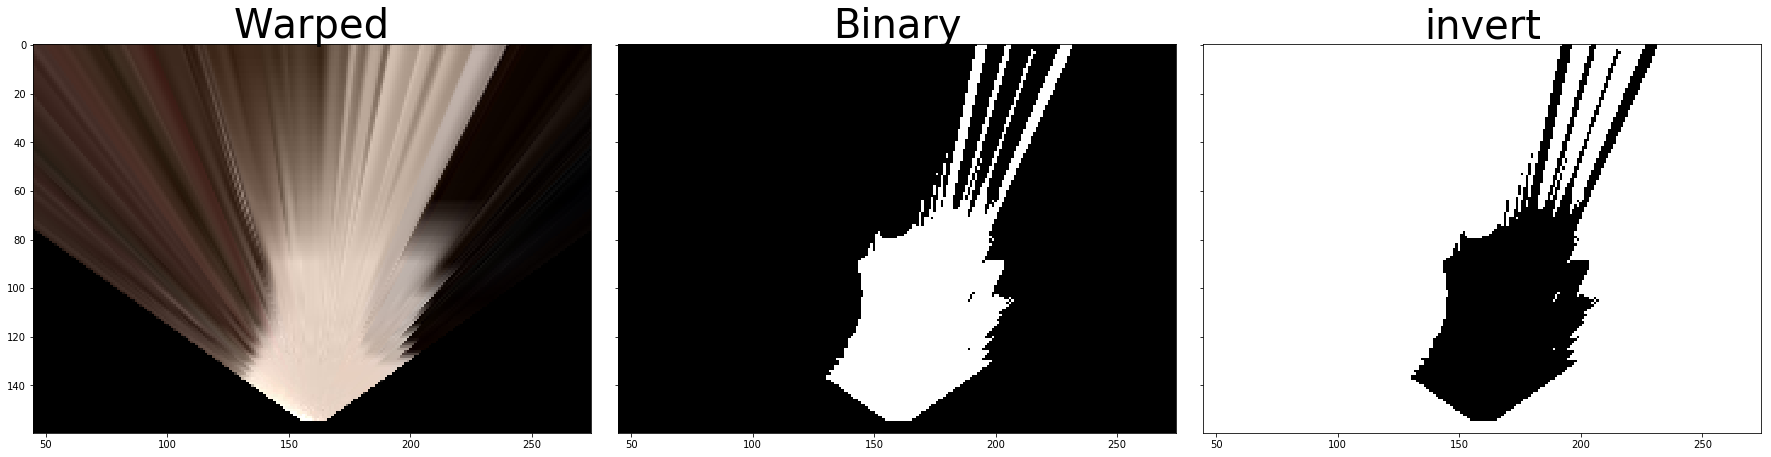

In [59]:
warped = perspect_transform1(image)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))
invert = 1 - colorsel 
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('Warped', fontsize=40)

ax2.imshow(colorsel, cmap='gray')
ax2.set_title('Binary', fontsize=40)

ax3.imshow(invert, cmap='gray')
ax3.set_title('invert', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 279/283 [00:16<00:00, 17.05it/s]

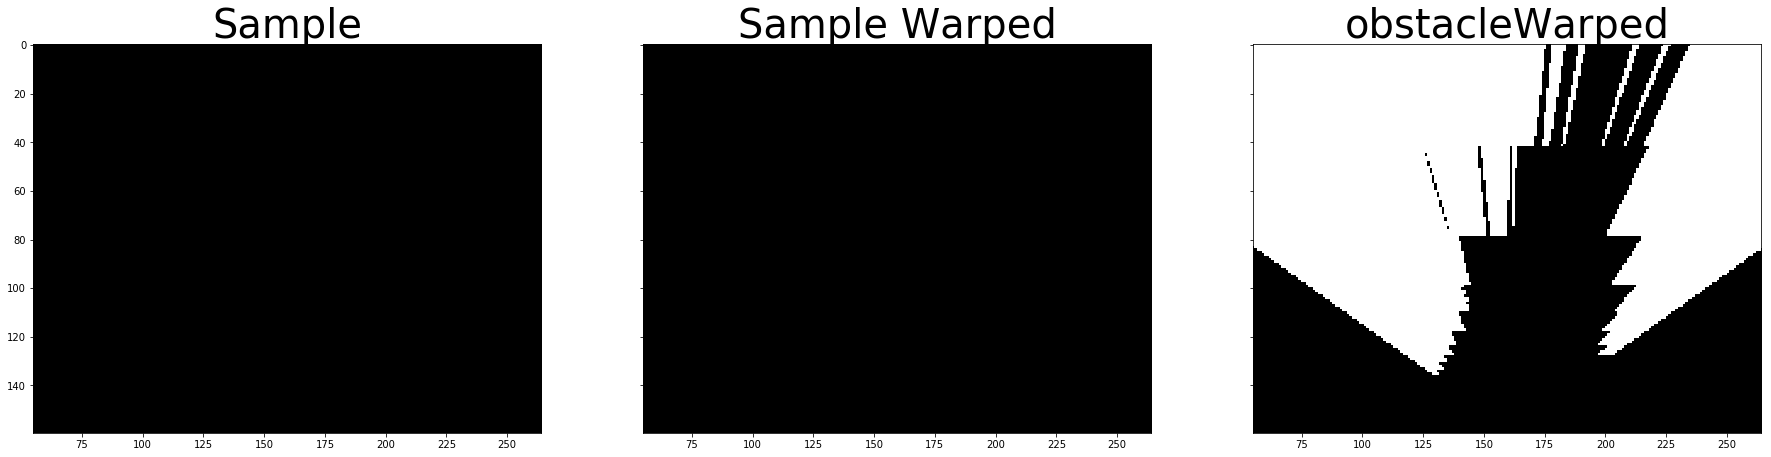

In [60]:
sample = sample_detect(image)
sampleWarped = perspect_transform1(sample)
obstacle =  obstacle_detect(image)
obstacleWarped = perspect_transform1(obstacle)
f, (ss1, ss2, ss3) = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
ss1.imshow(sample, cmap='gray')
ss1.set_title('Sample', fontsize=40)
ss2.set_title('Sample Warped', fontsize=40)
ss2.imshow(sampleWarped, cmap='gray')
ss3.set_title('obstacleWarped', fontsize=40)
ss3.imshow(obstacleWarped, cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


5156


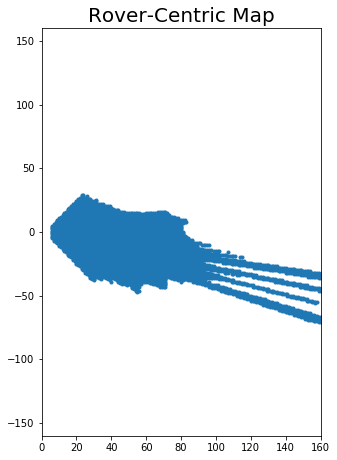

In [61]:
xpix, ypix = rover_coords(colorsel)
print(np.size(xpix))   
# Plot the map in rover-centric coords
fig = plt.figure(figsize=(5, 7.5))
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
plt.title('Rover-Centric Map', fontsize=20)
plt.show()

In [62]:
#define worldspace
# store initial position
initPosX = 98.62124
initPosY = 83.92326
initYaw = 57.83185

rover_xpos = initPosX
rover_ypos = initPosY
rover_yaw =initYaw

def rotate_pix(xpix, ypix, yaw):
    # TODO:
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # TODO:
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot/scale) + xpos
    ypix_translated = (ypix_rot/scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated

def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world
worldmap = np.zeros((200, 200))
scale = 10
# Get navigable pixel positions in world coords
x_world, y_world = pix_to_world(xpix, ypix, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                worldmap.shape[0], scale)
# Add pixel positions to worldmap
worldmap[y_world, x_world] += 1

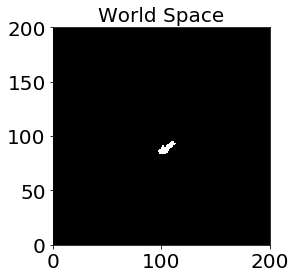

In [63]:
f,(ws) = plt.subplots()
ws.imshow(worldmap, cmap='gray')
ws.set_title('World Space', fontsize=20)
ws.set_ylim(0, 200)
ws.tick_params(labelsize=20)
ws.set_xlim(0, 200)

plt.show()

-0.187639771804
[-0.18763977]
max_travel_dist 175.045708316 selected_Course -10.7479752194 expected_travel_dist 80.4114419719


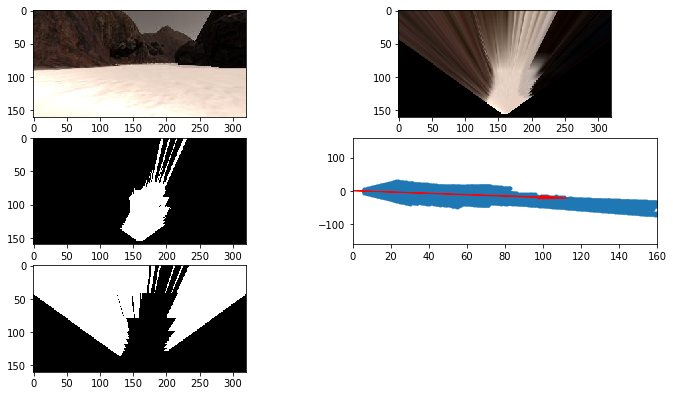

In [64]:
distances, angles = to_polar_coords(xpix, ypix) # Convert to polar coords
avg_angle = np.mean(angles) # Compute the average angle
print('max_travel_dist', np.max(distances), 'selected_Course', (avg_angle*180)/np.pi, 'expected_travel_dist', np.max(distAtAz(avg_angle,distances,angles)) )
# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(421)
plt.imshow(image)
plt.subplot(422)
plt.imshow(warped)
plt.subplot(423)
plt.imshow(colorsel, cmap='gray')
plt.subplot(424)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(avg_angle)
y_arrow = arrow_length * np.sin(avg_angle)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
plt.subplot(425)
plt.imshow(obstacleWarped, cmap='gray')
plt.show()

In [83]:
import pandas as pd
# Change this path to your data directory
df = pd.read_csv('E:\\udacity\\test_dataset\\robot_log.csv',sep=None)
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('E:\\udacity\\calibration_images\\map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = -1 # This will be a running index, setting to -1 is a hack
                        # because moviepy (below) seems to run one extra iteration
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


In [84]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    # 2) Apply perspective transform
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    # 4) Convert thresholded image pixel values to rover-centric coords
    # 5) Convert rover-centric pixel values to world coords
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    # constants
# defining worldspace
    while data.count < 283:
        scale = 10


        #apply perspective translation

        warped = perspect_transform1(img)

        #convert to binary

        colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))

        #check for Sample

        sample = sample_detect(img)
        sampleWarped = perspect_transform1(sample)

        #check for obstacle

        obstacle =  obstacle_detect(img)
        obstacleWarped = perspect_transform1(obstacle)

        #get Rover Position and Orientation

        rover_xpos = data.xpos
        rover_ypos = data.ypos
        rover_yaw = data.yaw
        # translate current detected environment to Rover Coodinates
        nxpix, nypix = rover_coords(colorsel)
        sxpix, sypix = rover_coords(sampleWarped)
        oxpix, oypix = rover_coords(obstacleWarped)

        # Get navigable and sample pixel positions in world coords
        o_x_world, o_y_world = pix_to_world(oxpix, oypix, rover_xpos[data.count], rover_ypos[data.count], rover_yaw[data.count], data.worldmap.shape[0], scale)
        n_x_world, n_y_world = pix_to_world(nxpix, nypix, rover_xpos[data.count], rover_ypos[data.count], rover_yaw[data.count], data.worldmap.shape[0], scale)
        s_x_world, s_y_world = pix_to_world(sxpix, sypix, rover_xpos[data.count], rover_ypos[data.count], rover_yaw[data.count], data.worldmap.shape[0], scale)
        # Add pixel positions to worldmap

        data.worldmap[o_y_world, o_x_world, 0] += 1
        data.worldmap[s_y_world, s_x_world, 1] += 1
        data.worldmap[n_y_world, n_x_world, 2] += 1

        # 7) Make a mosaic image, below is some example code
            # First create a blank image (can be whatever shape you like)
        output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
            # Next you can populate regions of the image with various output
            # Here I'm putting the original image in the upper left hand corner
        output_image[0:img.shape[0], 0:img.shape[1]] = img

            # Let's create more images to add to the mosaic, first a warped image
        #warped = perspect_transform(img, source, destination)
            # Add the warped image in the upper right hand corner
        output_image[0:img.shape[0], img.shape[1]:] = warped

            # Overlay worldmap with ground truth map
        map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
            # Flip map overlay so y-axis points upward and add to output_image 
        output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


            # Then putting some text over the image
        cv2.putText(output_image,"Output Video", (20, 20), 
                    cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
        data.count += 1 # Keep track of the index in the Databucket()
        #print(data.count)
        return output_image
    return 

In [85]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = 'E:\\udacity\\output\\test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video E:\udacity\output\test_mapping.mp4
[MoviePy] Writing video E:\udacity\output\test_mapping.mp4



100%|████████████████████████████████████████████████████████████████████████████████| 283/283 [00:03<00:00, 77.92it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: E:\udacity\output\test_mapping.mp4 

Wall time: 3.83 s


In [86]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))

In [87]:
df2 = pd.read_csv('E:\\udacity\\robot_log.csv',sep=None)
data.count = 0
csv_img_list = df2["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('E:\\udacity\\calibration_images\\map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

In [88]:
output1 = 'E:\\udacity\\output\\real.mp4'
#data.count = 0
data = Databucket() # Re-initialize data in case you're running this cell multiple times

clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output1, audio=False)

[MoviePy] >>>> Building video E:\udacity\output\real.mp4
[MoviePy] Writing video E:\udacity\output\real.mp4



 25%|███████████████████▉                                                           | 282/1120 [00:03<00:10, 78.28it/s]

AttributeError: 'NoneType' object has no attribute 'dtype'


 25%|███████████████████▉                                                           | 282/1120 [00:16<00:49, 17.04it/s]

In [25]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output1))

import io
import base64
video = io.open(output1, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))